Predicting Survival on Titanic Dataset
-------

We will try to predict which passengers survived using the titanic dataset. There will be three main steps:

1. Data Imputation: We will first explore the data to see which features have null entries and we will try to fill them in in a way that makes sense to us.

2. Feature Engineering: We will keep exploring the data and check how each feature affected survival to get an idea about which features will be useful for prediction, which won't. Here, we can also get more creative and add new features that we think might be useful for prediction based on the insight we get from data exploration.

3. Prediciton: Here happens the magic. Once our data is ready for prediction (no null entries, all non float/int values are converted into float/int), we can do an initial analysis to see which features affect prediction accuracy most. If we see some features are not that important, we can try to exclude them and see how it improves performance.


**1. Data Imputation**

In [178]:
#import necessary packages
# pandas
import pandas as pd

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

#scipy
from scipy.stats import mode


# scikit-learn (we are not gonna use all, but let's include all in case we want to improve in the future)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [179]:
# get training & test csv files as a DataFrame
train_data = pd.read_csv("train.csv")
test_data    = pd.read_csv("test.csv")

#let's combine training and test data for exploring the data
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# preview the data to get an idea and to see which column has null entries
print("Combined Data:")
combined_data.info()

print('---------------------------------------------------------')
#also, lets check the data to see what kind of info we have there
print(combined_data.head())

initial_data = combined_data.copy() #store the original data to compare with the filled in data later on

Combined Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
---------------------------------------------------------
    Age Cabin Embarked     Fare  \
0  22.0   NaN        S   7.2500   
1  38.0   C85        C  71.2833   
2  26.0   NaN        S   7.9250   
3  35.0  C123        S  53.1000   
4  35.0   NaN        S   8.0500   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr.

    Here, we discovered that age, cabin, fare and embarked have null entries 
    We will have to fill them in later on 
    ------------------FILL NULL ENTRIES: IMPUTATION--------------------------------

In [180]:
#-------------AGE--------------------------------------------------------------
#Let's play with age data first
print(mode(combined_data['Age'])) #get the most frequent age value --> might use that to fill in null age values


#or even better, we can find the median age based on people's title
#and assign that value for null ages depending on the name of the passenger
#first, find all the available titles
titles = []
for i in range(0,1308): 
    titles.append(combined_data.Name.str.split(", ")[i][1].split(' ')[0])

#lets get the unique title values   
unique_titles = np.unique(np.array(titles))
print(unique_titles)

ModeResult(mode=array([ 24.]), count=array([47]))
['Capt.' 'Col.' 'Don.' 'Dona.' 'Dr.' 'Jonkheer.' 'Lady.' 'Major.' 'Master.'
 'Miss.' 'Mlle.' 'Mme.' 'Mr.' 'Mrs.' 'Ms.' 'Rev.' 'Sir.' 'the']


    We see that we have many titles: 'Capt.', 'Col.', 'Don.','Dona.','Dr.','Jonkheer.','Lady.',
    'Major.','Master.','Miss.','Mlle.','Mme.','Mr.',Mrs.','Ms.','Rev.','Sir.','the']

    Let's count each unique value to see which are the most common and categorize the rest as 'rest title'

    Lets check first how many Mr., Mrs. and Miss we have, if they are the majority, we can categorize the rest 
    as rest

In [181]:
print(titles.count('Mrs.')+titles.count('Mr.')+titles.count('Miss.')) #1214

1214


    1214/1309 titles are Mrs./Mr./Miss., we can safely categorize the rest as 'rest'

    We can create another variable called 'title' that might help us assign null age values as well as for 
    prediction later on.

<IPython.core.display.Javascript object>


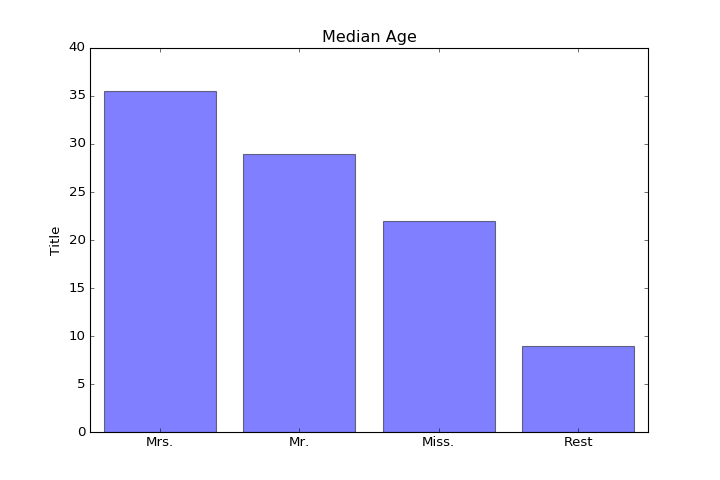

In [182]:
#0 = Mrs, 1 = Mr., 2 = Miss., 3 = rest 
pd.options.mode.chained_assignment = None  # default='warn', supress warning 
combined_data['Title'] = ''
combined_data['Title'][combined_data['Name'].str.contains('Mrs.')] = 0
combined_data['Title'][(combined_data['Name'].str.contains('Mr.')) & (combined_data['Name'].str.contains('Mrs.')==False)] =1 #make sure that in Mr. is not included as Mrs. substring includes Mr. as well
combined_data['Title'][combined_data['Name'].str.contains('Miss.')] = 2
combined_data['Title'][(combined_data['Name'].str.contains('Mrs.') == False) & (combined_data['Name'].str.contains('Mr.') == False) & (combined_data['Name'].str.contains('Miss.') == False)] = 3
combined_data.drop(['Name'],axis=1,inplace=True)
#convert into float
combined_data['Title'] = combined_data['Title'].astype(float)


#get median, mean age and std per title
median_age_mrs = combined_data[combined_data['Title'] == 0].Age.median()
median_age_mr = combined_data[combined_data['Title'] == 1].Age.median()
median_age_miss = combined_data[combined_data['Title'] == 2].Age.median()
median_age_rest = combined_data[combined_data['Title'] == 3].Age.median()
mean_age_mrs = combined_data[combined_data['Title'] == 0].Age.mean()
mean_age_mr = combined_data[combined_data['Title'] == 1].Age.mean()
mean_age_miss = combined_data[combined_data['Title'] == 2].Age.mean()
mean_age_rest = combined_data[combined_data['Title'] == 3].Age.mean()
std_age_mrs = combined_data[combined_data['Title'] == 0].Age.std()
std_age_mr = combined_data[combined_data['Title'] == 1].Age.std()
std_age_miss = combined_data[combined_data['Title'] == 2].Age.std()
std_age_rest = combined_data[combined_data['Title'] == 3].Age.std()
ages = [median_age_mrs,median_age_mr,median_age_miss,median_age_rest]

#lets visualize the age differences between title groups
fig = plt.figure(2, figsize=(9, 6))#new figure
ax2 = fig.add_subplot(111)
titles = ('Mrs.', 'Mr.', 'Miss.', 'Rest')
y_pos = np.arange(len(titles))

plt.bar(y_pos, ages, align='center', alpha=0.5)
plt.xticks(y_pos, titles)
plt.ylabel('Title')
plt.title('Median Age')
plt.show()

    As we can see here, there is a huge difference in age between people with
    different titles. We can use that as a hint to replace null values
    you can also use mean instead of median, though median makes more sense to me

<IPython.core.display.Javascript object>


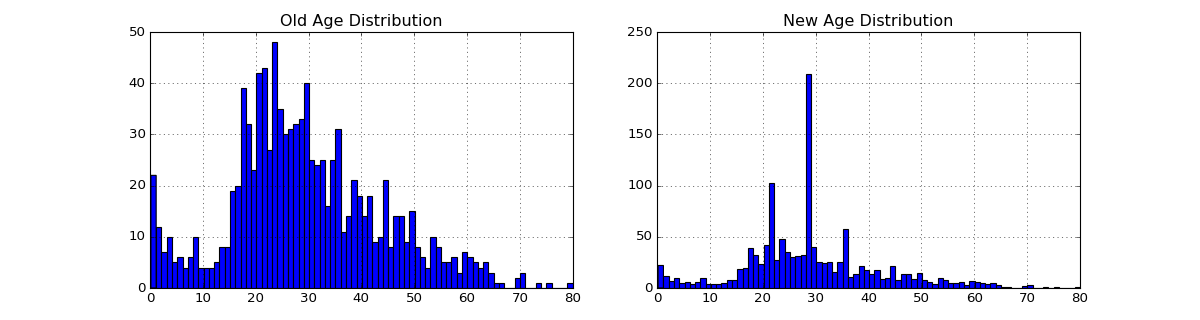

In [183]:
combined_data.set_value((combined_data['Title'] == 0) & (combined_data['Age'].isnull()),'Age',median_age_mrs)
combined_data.set_value((combined_data['Title'] == 1) & (combined_data['Age'].isnull()),'Age',median_age_mr)
combined_data.set_value((combined_data['Title'] == 2) & (combined_data['Age'].isnull()),'Age',median_age_miss)
combined_data.set_value((combined_data['Title'] == 3) & (combined_data['Age'].isnull()),'Age',median_age_miss)

# plots plot a histogram again to see the old and new distribution together
fig, (ax3,ax4) = plt.subplots(1,2,figsize=(15,4))
ax3.set_title('Old Age Distribution')
ax4.set_title('New Age Distribution')
initial_data['Age'].dropna().hist(bins = 80, ax=ax3) #old distribution without the null entries
combined_data['Age'].hist(bins=80, ax=ax4)

    hmm, the new distribution looks quite different as there were many null values for age for people with 
    Mr. title maybe it is better to assign the new age from a random distribution rather than the median

<IPython.core.display.Javascript object>


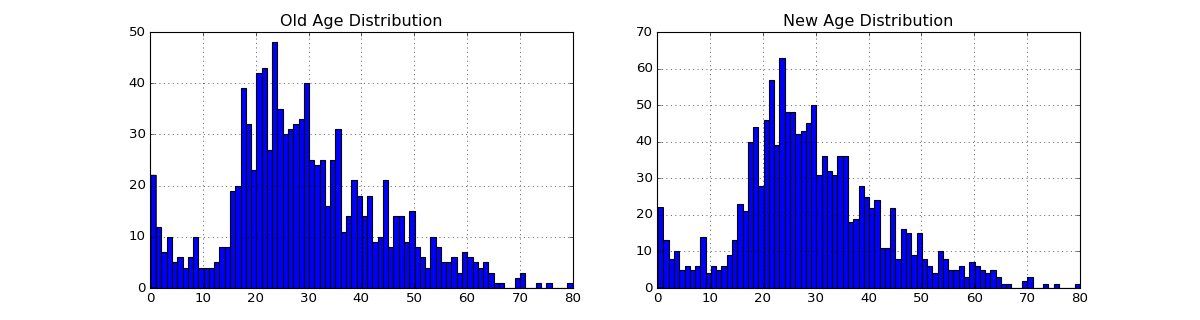

In [184]:
num_nan_mrs_age = len(initial_data[(combined_data['Title']==0) & (initial_data['Age'].isnull())].Age) #number of null entries for mrs.
rand_mrs = np.random.randint(mean_age_mrs - std_age_mrs, mean_age_mrs + std_age_mrs, size = num_nan_mrs_age)
num_nan_mr_age = len(initial_data[(combined_data['Title']==1) & (initial_data['Age'].isnull())].Age)
rand_mr = np.random.randint(mean_age_mr - std_age_mr, mean_age_mr + std_age_mr, size = num_nan_mr_age)
num_nan_miss_age = len(initial_data[(combined_data['Title']==2) & (initial_data['Age'].isnull())].Age)
rand_miss = np.random.randint(mean_age_miss - std_age_miss, mean_age_miss + std_age_miss, size = num_nan_miss_age)
num_nan_rest_age = len(initial_data[(combined_data['Title']==3) & (initial_data['Age'].isnull())].Age)
rand_rest = np.random.randint(mean_age_rest - std_age_rest, mean_age_rest + std_age_rest, size = num_nan_rest_age)


combined_data.set_value((combined_data['Title']==0) & (initial_data['Age'].isnull()),'Age',rand_mrs)
combined_data.set_value((combined_data['Title']==1) & (initial_data['Age'].isnull()),'Age',rand_mr)
combined_data.set_value((combined_data['Title']==2) & (initial_data['Age'].isnull()),'Age',rand_miss)
combined_data.set_value((combined_data['Title']==3) & (initial_data['Age'].isnull()),'Age',rand_rest)


#lets draw again old and new data to see the age distribution
fig, (ax3,ax4) = plt.subplots(1,2,figsize=(15,4))
ax3.set_title('Old Age Distribution')
ax4.set_title('New Age Distribution')
initial_data['Age'].dropna().hist(bins = 80, ax=ax3) #old distribution without the null entries
combined_data['Age'].hist(bins=80, ax=ax4)


    Looks better

In [185]:
#-------------CABIN------------------------------------------------------------
#there are 1014 null entries for cabin (we printed that info in the beginning)
#hence cabin information is unlikely to be useful for prediction. Let's drop it:
combined_data.drop(['Cabin'],axis=1,inplace=True)


In [186]:
#-------------EMBARKED---------------------------------------------------------
#there are 1307 entries for embarked (we printed that info in the beginning)
#so only 2 null values need to be filled
#let's see what the most frequent embarked value is and use that to fill in null entries
print(combined_data[combined_data['Embarked']=='S'].Embarked.count())
print(combined_data[combined_data['Embarked']=='C'].Embarked.count())
print(combined_data[combined_data['Embarked']=='Q'].Embarked.count())

914
270
123


    so, 'S' is the most common embark station with 644 entries, let's fill in the null entries with 'S' then

In [187]:
combined_data.set_value(combined_data['Embarked'].isnull(),'Embarked','S')

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,S,7.2500,0,1,3,male,1,0.0,A/5 21171,1.0
1,38.0,C,71.2833,0,2,1,female,1,1.0,PC 17599,0.0
2,26.0,S,7.9250,0,3,3,female,0,1.0,STON/O2. 3101282,2.0
3,35.0,S,53.1000,0,4,1,female,1,1.0,113803,0.0
4,35.0,S,8.0500,0,5,3,male,0,0.0,373450,1.0
5,34.0,Q,8.4583,0,6,3,male,0,0.0,330877,1.0
6,54.0,S,51.8625,0,7,1,male,0,0.0,17463,1.0
7,2.0,S,21.0750,1,8,3,male,3,0.0,349909,3.0
8,27.0,S,11.1333,2,9,3,female,0,1.0,347742,0.0
9,14.0,C,30.0708,0,10,2,female,1,1.0,237736,0.0


In [188]:
#--------------FARE------------------------------------------------------------
#only 1 fare value is missing, we can simply use the median to fill it in
combined_data['Fare'][combined_data['Fare'].isnull()] = combined_data['Fare'].median()
#-------------------------------END IMPUTATION---------------------------------

    --------------EXPLORE DATA FOR PREDICTION: FEATURE ENGINEERING----------------
    lets explore the data to see what kind of information is useful to predict survival

<IPython.core.display.Javascript object>


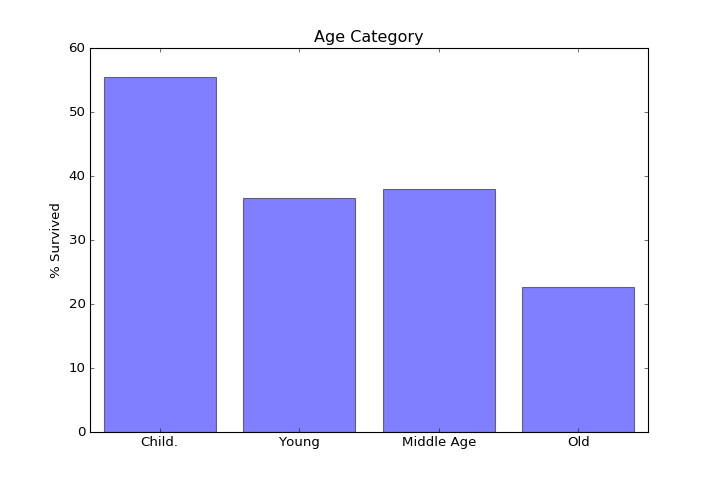

In [189]:
#AGE
#age could be useful in the sense that children could have been priority for survival 
#or elder people might have failed to survive
#To explore that, let's divide the passengers into 4 age groups: child<12, 12<young<30
# 30<middle<60 old>60
combined_data["AgeCategory"] = ''
combined_data.set_value((combined_data["Age"]<=12),'AgeCategory',0) #child
combined_data.set_value(((combined_data["Age"]>12) & (combined_data["Age"]<=30)),'AgeCategory',1) #young
combined_data.set_value(((combined_data["Age"]>30)& (combined_data["Age"]<=60)),'AgeCategory',2) #middle age
combined_data.set_value((combined_data["Age"]>60),'AgeCategory',3) #old

#lets visualize how age category changes survial
fig = plt.figure(5, figsize=(9, 6))#new figure
ax5 = fig.add_subplot(111)
titles = ('Child.', 'Young', 'Middle Age', 'Old')
y_pos = np.arange(len(titles))
survival_rate_child = 100*len(combined_data[(combined_data['AgeCategory']==0) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['AgeCategory']==0) & (combined_data['Survived'].isnull()==False)])
survival_rate_young = 100*len(combined_data[(combined_data['AgeCategory']==1) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['AgeCategory']==1) & (combined_data['Survived'].isnull()==False)])
survival_rate_middle = 100*len(combined_data[(combined_data['AgeCategory']==2) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['AgeCategory']==2) & (combined_data['Survived'].isnull()==False)])
survival_rate_old = 100*len(combined_data[(combined_data['AgeCategory']==3) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['AgeCategory']==3) & (combined_data['Survived'].isnull()==False)])
survival_rate = [survival_rate_child, survival_rate_young, survival_rate_middle, survival_rate_old]

plt.bar(y_pos, survival_rate, align='center', alpha=0.5)
plt.xticks(y_pos, titles)
plt.ylabel('% Survived')
plt.title('Age Category')
plt.show()

combined_data['AgeCategory'] = combined_data['AgeCategory'].astype(float)

    it looks like children really survived more and elder people less
    hence, age will probably an important variable for predicting survival


In [190]:
#FARE
#lets categorize fares as cheap, middle expensive and expensive and see how that correlates with survival
#let's get an ide about the range, min & max values first
print(combined_data.Fare.min()) #0
print(combined_data.Fare.max()) #512
print(combined_data.Fare.median()) # 14.4542

0.0
512.3292
14.4542


<IPython.core.display.Javascript object>


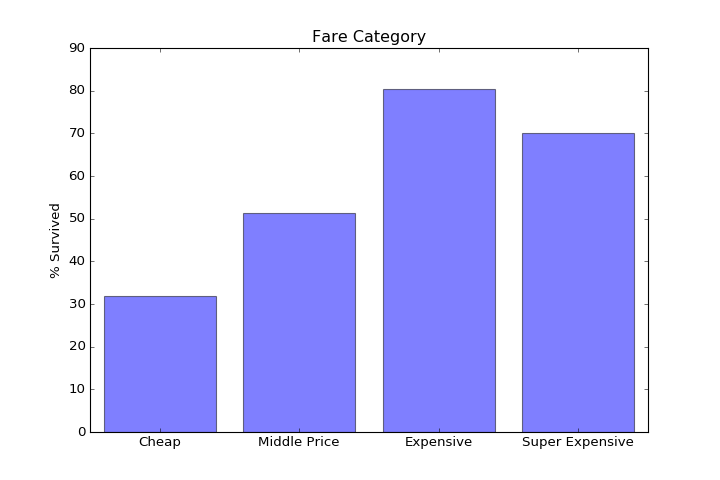

In [191]:
#lets say cheap < mean, middle < mean+std, expensive > mean+std, super expensive > mean+3*std
combined_data["FareCategory"] = ''
combined_data.set_value((combined_data["Fare"]<=(combined_data.Fare.mean())),'FareCategory',0) #cheap
combined_data.set_value(((combined_data["Fare"]>combined_data.Fare.mean())&(combined_data["Fare"]<(combined_data.Fare.mean()+combined_data.Fare.std()))),'FareCategory',1) #middle range
combined_data.set_value(((combined_data["Fare"]>(combined_data.Fare.mean()+combined_data.Fare.std()))&(combined_data["Fare"]<(combined_data.Fare.mean()+3*combined_data.Fare.std()))),'FareCategory',2) #expensive
combined_data.set_value((combined_data["Fare"]>(combined_data.Fare.mean()+3*combined_data.Fare.std())),'FareCategory',3) #super expensive
#lets visualize how age category changes survial
fig = plt.figure(6, figsize=(9, 6))#new figure
ax6 = fig.add_subplot(111)
titles = ('Cheap', 'Middle Price', 'Expensive', 'Super Expensive')
y_pos = np.arange(len(titles))
survival_rate_cheap = 100*len(combined_data[(combined_data['FareCategory']==0) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['FareCategory']==0) & (combined_data['Survived'].isnull()==False)])
survival_rate_mid = 100*len(combined_data[(combined_data['FareCategory']==1) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['FareCategory']==1) & (combined_data['Survived'].isnull()==False)])
survival_rate_exp = 100*len(combined_data[(combined_data['FareCategory']==2) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['FareCategory']==2) & (combined_data['Survived'].isnull()==False)])
survival_rate_supexp = 100*len(combined_data[(combined_data['FareCategory']==3) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['FareCategory']==3) & (combined_data['Survived'].isnull()==False)])
survival_rate = [survival_rate_cheap, survival_rate_mid, survival_rate_exp, survival_rate_supexp]

plt.bar(y_pos, survival_rate, align='center', alpha=0.5)
plt.xticks(y_pos, titles)
plt.ylabel('% Survived')
plt.title('Fare Category')
plt.show()

combined_data['FareCategory'] = combined_data['FareCategory'].astype(float)

<IPython.core.display.Javascript object>


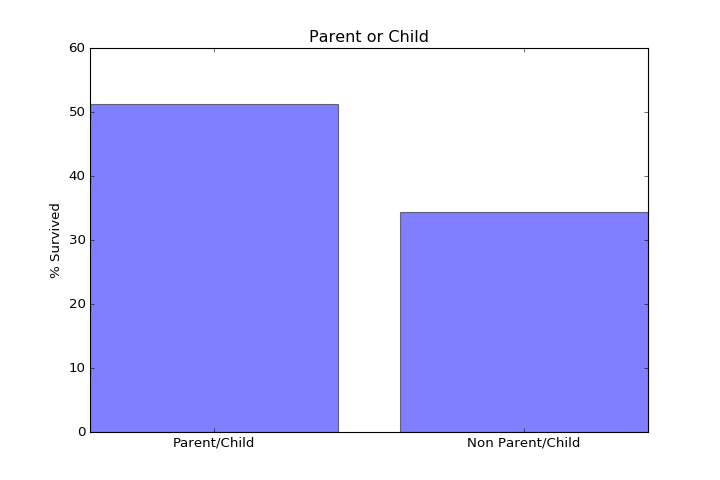

In [192]:
#PARCH
#let's see if being a parent or child affects survival
fig = plt.figure(7, figsize=(9, 6))#new figure
ax7 = fig.add_subplot(111)
titles = ('Parent/Child','Non Parent/Child')
y_pos = np.arange(len(titles))
survival_rate_pc = 100*len(combined_data[(combined_data['Parch']>0) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['Parch'] >0) & (combined_data['Survived'].isnull()==False)])
survival_rate_npc = 100*len(combined_data[(combined_data['Parch']==0) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['Parch']==0) & (combined_data['Survived'].isnull()==False)])
survival_rate = [survival_rate_pc, survival_rate_npc]

plt.bar(y_pos, survival_rate, align='center', alpha=0.5)
plt.xticks(y_pos, titles)
plt.ylabel('% Survived')
plt.title('Parent or Child')
plt.show()

<IPython.core.display.Javascript object>


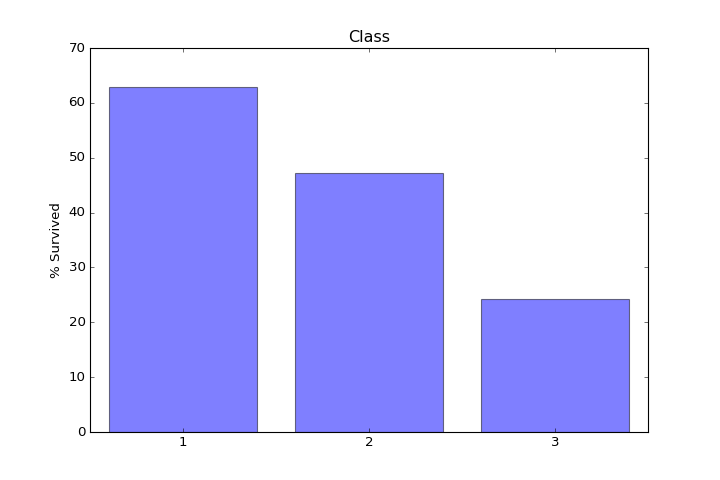

In [193]:
#it looks like people who had a parent or children on board survived more

#PCLASS
#let's see if the class of the passenger affects survival
fig = plt.figure(8, figsize=(9, 6))#new figure
ax8 = fig.add_subplot(111)
titles = ('1','2','3')
y_pos = np.arange(len(titles))
survival_rate_first = 100*len(combined_data[(combined_data['Pclass']==1) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['Pclass'] ==1) & (combined_data['Survived'].isnull()==False)])
survival_rate_second = 100*len(combined_data[(combined_data['Pclass']==2) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['Pclass']==2) & (combined_data['Survived'].isnull()==False)])
survival_rate_third = 100*len(combined_data[(combined_data['Pclass']==3) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['Pclass']==3) & (combined_data['Survived'].isnull()==False)])
survival_rate = [survival_rate_first, survival_rate_second,survival_rate_third]

plt.bar(y_pos, survival_rate, align='center', alpha=0.5)
plt.xticks(y_pos, titles)
plt.ylabel('% Survived')
plt.title('Class')
plt.show()

    people who traveled in the 1st class survived more than the rest

<IPython.core.display.Javascript object>


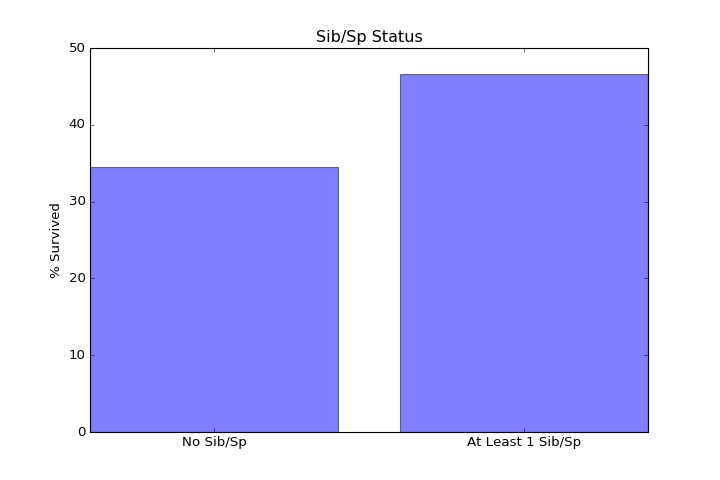

In [194]:
#SibSp
#let's see if having a spouse or sibling affects survival
fig = plt.figure(9, figsize=(9, 6))#new figure
ax9 = fig.add_subplot(111)
titles = ('No Sib/Sp','At Least 1 Sib/Sp')
y_pos = np.arange(len(titles))
survival_rate_nosbsp = 100*len(combined_data[(combined_data['SibSp']==0) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['SibSp'] ==0) & (combined_data['Survived'].isnull()==False)])
survival_rate_sbsp = 100*len(combined_data[(combined_data['SibSp']>0) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['SibSp']>0) & (combined_data['Survived'].isnull()==False)])
survival_rate = [survival_rate_nosbsp, survival_rate_sbsp]

plt.bar(y_pos, survival_rate, align='center', alpha=0.5)
plt.xticks(y_pos, titles)
plt.ylabel('% Survived')
plt.title('Sib/Sp Status')
plt.show()

    people who had at least 1 sibling or spouse seem to have survived more

    But I think there might be a penalty of traveling completely alone. We can check
    that combining the info in Parch and SibSp
    let's create a new variable called Solo to see how that affects survival

<IPython.core.display.Javascript object>


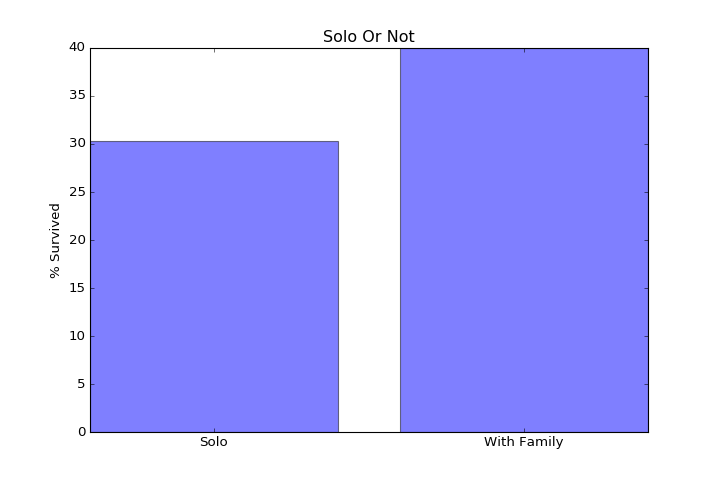

In [195]:
combined_data["Solo"] = ''
combined_data.set_value((combined_data["Parch"]>0)|(combined_data["SibSp"]>0),'Solo',0) #not solo
combined_data.set_value((combined_data["Parch"]==0)&(combined_data["SibSp"]==0),'Solo',1) #solo
#lets visualize how age category changes survial
fig = plt.figure(10, figsize=(9, 6))#new figure
ax10 = fig.add_subplot(111)
titles = ('Solo', 'With Family')
y_pos = np.arange(len(titles))
survival_rate_solo = 100*len(combined_data[(combined_data['Solo']==1) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['Parch']==0) & (combined_data['SibSp']==0) & (combined_data['Survived'].isnull()==False)])
survival_rate_nsolo = 100*len(combined_data[(combined_data['Solo']==0) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['Parch']>0) | (combined_data['SibSp']>0) & (combined_data['Survived'].isnull()==False)])
survival_rate = [survival_rate_solo, survival_rate_nsolo]

plt.bar(y_pos, survival_rate, align='center', alpha=0.5)
plt.xticks(y_pos, titles)
plt.ylabel('% Survived')
plt.title('Solo Or Not')
plt.show()

combined_data["Solo"] = combined_data["Solo"].astype(float)

    less prominent than I expected but still solo travelers tend to survive less

<IPython.core.display.Javascript object>


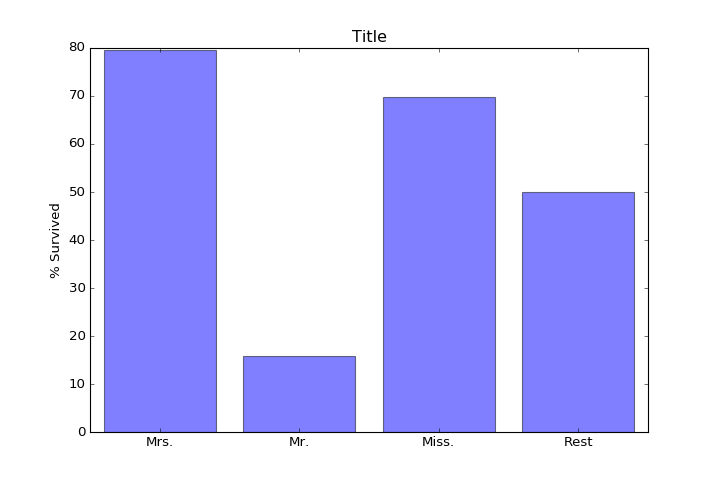

In [196]:
#NAME
#we already created a new variable called 'Title' that could be usefil for prediction
#let's see how survival changes depending on the title
fig = plt.figure(11, figsize=(9, 6))#new figure
ax11 = fig.add_subplot(111)
titles = ('Mrs.', 'Mr.', 'Miss.', 'Rest')
y_pos = np.arange(len(titles))
survival_rate_mrs = 100*len(combined_data[(combined_data['Title']==0) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['Title']==0) & (combined_data['Survived'].isnull()==False)])
survival_rate_mr = 100*len(combined_data[(combined_data['Title']==1) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['Title']==1) & (combined_data['Survived'].isnull()==False)])
survival_rate_miss = 100*len(combined_data[(combined_data['Title']==2) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['Title']==2) & (combined_data['Survived'].isnull()==False)])
survival_rate_rest = 100*len(combined_data[(combined_data['Title']==3) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['Title']==3) & (combined_data['Survived'].isnull()==False)])
survival_rate = [survival_rate_mrs, survival_rate_mr, survival_rate_miss, survival_rate_rest]

plt.bar(y_pos, survival_rate, align='center', alpha=0.5)
plt.xticks(y_pos, titles)
plt.ylabel('% Survived')
plt.title('Title')
plt.show()

    we can see clearly form the graph that people with title Mrs., Miss. and Rest 
    survived much better than Mr.
    hence, title will probably be an important factor for prediction

<IPython.core.display.Javascript object>


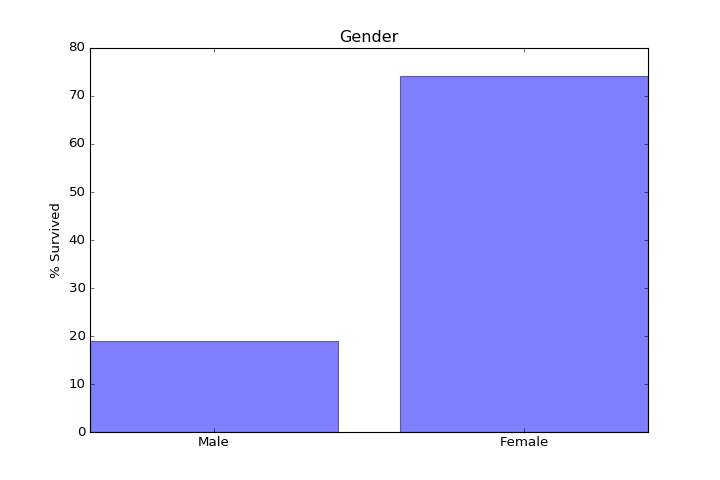

In [197]:
#SEX
#lets convert string sex entries into float
combined_data['Gender'] = ''
combined_data['Gender'][combined_data['Sex'] == 'male'] = 0
combined_data['Gender'][combined_data['Sex'] == 'female'] = 1
combined_data.drop(['Sex'],axis=1,inplace=True)
#convert into float
combined_data['Gender'] = combined_data['Gender'].astype(float)

#let's see how survival changes depending on gender
fig = plt.figure(12, figsize=(9, 6))#new figure
ax12 = fig.add_subplot(111)
titles = ('Male', 'Female')
y_pos = np.arange(len(titles))
survival_rate_male = 100*len(combined_data[(combined_data['Gender']==0) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['Gender']==0) & (combined_data['Survived'].isnull()==False)])
survival_rate_female = 100*len(combined_data[(combined_data['Gender']==1) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['Gender']==1) & (combined_data['Survived'].isnull()==False)])
survival_rate = [survival_rate_male, survival_rate_female]

plt.bar(y_pos, survival_rate, align='center', alpha=0.5)
plt.xticks(y_pos, titles)
plt.ylabel('% Survived')
plt.title('Gender')
plt.show()

    female passengers tend to survive significantly more than male passengers
    hence, sex will probably be an important factor for prediction

In [198]:
#TICKET
#the ticket information is unlikely to be unsefull, so let's drop it
combined_data.drop(['Ticket'],axis=1,inplace = True)

<IPython.core.display.Javascript object>


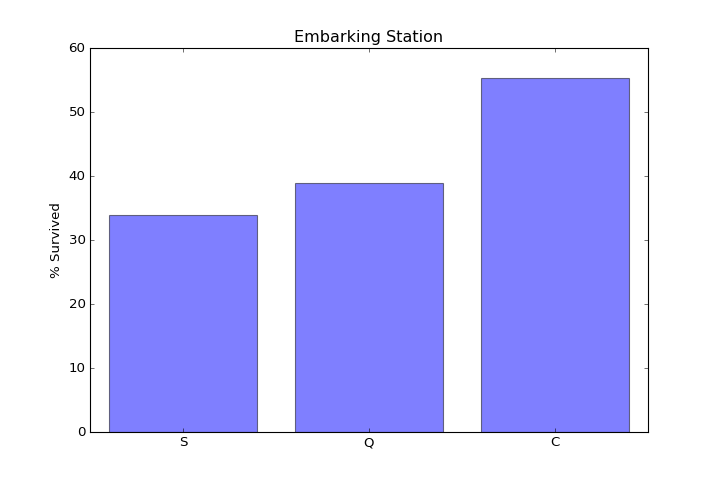

In [199]:
#EMBARAKED
# S = 0, Q = 1, C = 2
combined_data['NewEmbarked'] = ''
combined_data['NewEmbarked'][combined_data['Embarked']=='S'] = 0
combined_data['NewEmbarked'][combined_data['Embarked']=='Q'] = 1
combined_data['NewEmbarked'][combined_data['Embarked']=='C'] = 2
combined_data.drop(['Embarked'],axis=1,inplace=True)
#convert into float
combined_data['NewEmbarked'] = combined_data['NewEmbarked'].astype(float)

#lets visualize how embarking port affects survival
fig = plt.figure(13, figsize=(9, 6))#new figure
ax13 = fig.add_subplot(111)
titles = ('S', 'Q','C')
y_pos = np.arange(3)
survival_rate_s = 100*len(combined_data[(combined_data['NewEmbarked']==0) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['NewEmbarked']==0) & (combined_data['Survived'].isnull()==False)])
survival_rate_q = 100*len(combined_data[(combined_data['NewEmbarked']==1) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['NewEmbarked']==1) & (combined_data['Survived'].isnull()==False)])
survival_rate_c = 100*len(combined_data[(combined_data['NewEmbarked']==2) & (combined_data['Survived']==1)])/len(combined_data[(combined_data['NewEmbarked']==2) & (combined_data['Survived'].isnull()==False)])
survival_rate = [survival_rate_s, survival_rate_q,survival_rate_c]

plt.bar(y_pos, survival_rate, align='center', alpha=0.5)
plt.xticks(y_pos, titles)
plt.ylabel('% Survived')
plt.title('Embarking Station')
plt.show()
#------------------------END FEATURE ENGINEERING-------------------------------

    It seems like embarking port also played a role during survival

Ranking of features for prediction:
1. 1 Fare (0.230374)
2. 0 Age (0.215943)
3. 9 Gender (0.196766)
4. 5 Title (0.087283)
5. 3 Pclass (0.078650)
6. 4 SibSp (0.044414)
7. 6 AgeCategory (0.037345)
8. 10 NewEmbarked (0.034037)
9. 7 FareCategory (0.030896)
10. 2 Parch (0.028923)
11. 8 Solo (0.015370)


<IPython.core.display.Javascript object>


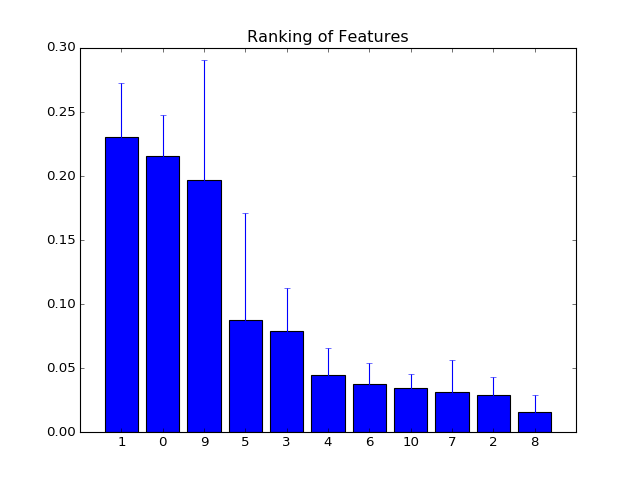

In [200]:
#----------------------------------PREDICTION----------------------------------
combined_data.drop('PassengerId',axis=1,inplace=True)
#let's divide into training and test data again
#let's try to predict using all the features
X_train = combined_data.drop(combined_data[[5]],axis=1)[0:len(train_data)]
Y_train = combined_data["Survived"][0:len(train_data)]
X_test  = combined_data.drop(combined_data[[5]],axis=1)[len(train_data):-1]

#Prediction with Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)

fimp = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_],
             axis=0)
ind = np.argsort(fimp)[::-1] #indices sorted by importance

# Let's print the importance of each feature in prediction
print("Ranking of features for prediction:")

for i in range(X_train.shape[1]):
    print("%d. %d %s (%f)" % (i + 1, ind[i], X_train.columns.values[ind[i]], fimp[ind[i]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Ranking of Features")
plt.bar(range(X_train.shape[1]), fimp[ind],yerr=std[ind], align="center")
plt.xticks(range(X_train.shape[1]), ind)
plt.xlim([-1, X_train.shape[1]])
plt.show()

    It looks like feature Solo was not so useful for prediction. Let's try predicting
    excluding these and see if it improves the performance

In [201]:
X_train = combined_data.drop(combined_data[[5,9]],axis=1)[0:len(train_data)]
Y_train = combined_data["Survived"][0:len(train_data)]
X_test  = combined_data.drop(combined_data[[5,9]],axis=1)[len(train_data)::]

#Prediction with Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test).astype(int)
random_forest.score(X_train, Y_train)


#let's write our prediction into a file
results = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "Survived": Y_pred
    })
results.to_csv('prediction.csv', index=False)

    Voila!!    